In [64]:
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [65]:
movie_file = Path("Movie_RawDataset.csv")

movie_df = pd.read_csv(movie_file)

movie_df['Director'] = movie_df['Director'].str.replace('Directors:', '')
movie_df.head()

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,Movie Rated,Language,Awards,Rotten Tomatoes Rating,IMDb Rating,Metascore,IMDb ID,Box Office,Rotten Tomatoes,imdbID
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,Gross Unkown,Action,"Adventure, Drama",Not Rated,Kannada,12 wins & 8 nominations,80%,8.2,NaN,NaN,NaN,Rating not found,tt15327088
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",PG-13,"English, Mandarin",Won 2 Oscars. 163 wins & 164 nominations total,94%,9.0,84,NaN,"$534,987,076",Rating not found,tt0468569
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama",PG-13,"English, Quenya, Old English, Sindarin",Won 11 Oscars. 215 wins & 124 nominations total,94%,9.0,94,NaN,"$379,427,292",Rating not found,tt0167260
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi",PG-13,"English, Japanese, French",Won 4 Oscars. 159 wins & 220 nominations total,87%,8.8,74,NaN,"$292,587,330",Rating not found,tt1375666
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama",PG-13,"English, Sindarin, Old English",Won 2 Oscars. 132 wins & 138 nominations total,95%,8.8,87,NaN,"$342,952,511",Rating not found,tt0167261


In [78]:
#Filtering (Cleaning) movie_df

df_unique = movie_df.drop_duplicates(subset='Movie_Title', keep='first')
filter_criteria = (
    (df_unique['Metascore'].notna()) &
    (df_unique['Box Office'].notna()) &
    (df_unique['Metascore'] != 'Rating not found') &
    (df_unique['Box Office'] != 'Box Office not found') &
    (df_unique['Total_Gross'] != 'Gross Unknown')
)
clean_movie_df = df_unique[filter_criteria]


### The input cell below groups the data by "Single Director" and "Multiple Directors"

In [67]:
# Create a new column "Director_Type" based on the number of directors
clean_movie_df['Director_Type'] = clean_movie_df['Director'].apply(lambda x: 'Multiple Directors' if ',' in x else 'Single Director')

# Group the DataFrame by the "Director_Type" column
grouped_director_type = clean_movie_df.groupby('Director_Type')

# Print the count of movies in each group
# for director_type, group in grouped_director_type:
#     print(f"Director Type: {director_type}")
#     print(group[['Movie_Title', 'Director']])
#     print()


grouped_director_type

C:\Users\jvvil\AppData\Local\Temp\ipykernel_24992\1581514390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_movie_df['Director_Type'] = clean_movie_df['Director'].apply(lambda x: 'Multiple Directors' if ',' in x else 'Single Director')


### The input cell below splits "Multiple Directors" into individual elements

In [68]:
# Identify rows with multiple directors
multiple_directors_mask = clean_movie_df['Director'].str.contains(',')

# Split multiple directors into individual values and create new rows
multiple_directors_df = clean_movie_df[multiple_directors_mask].copy()
multiple_directors_df['Director'] = multiple_directors_df['Director'].str.split(', ')
multiple_directors_df = multiple_directors_df.explode('Director')

# Combine the original DataFrame with the new rows for multiple directors
updated_movie_df = pd.concat([clean_movie_df[~multiple_directors_mask], multiple_directors_df], ignore_index=True)

In [69]:
updated_movie_df['Director_Type'].count()

822

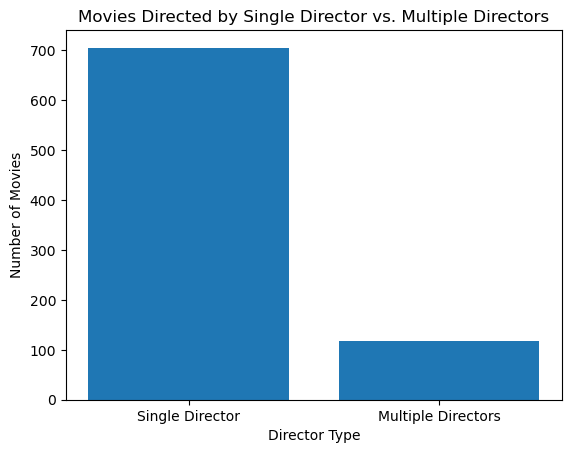

Of the ~6000 Top Movies, 85.77% were directed by an individual director, whereas 14.23% were directed by multiple directors


In [70]:
director_counts = updated_movie_df['Director_Type'].value_counts()
plt.bar(director_counts.index, director_counts.values)
plt.xlabel('Director Type')
plt.ylabel('Number of Movies')
plt.title('Movies Directed by Single Director vs. Multiple Directors')
plt.show();
single_director_percent = 705 / 822 * 100
rounded_single = round(single_director_percent, 2)
multiple_director_percent = 117 / 822 * 100
rounded_multiple = round(multiple_director_percent, 2)
print(f"Of the ~6000 Top Movies, {rounded_single}% were directed by an individual director, whereas {rounded_multiple}% were directed by multiple directors")

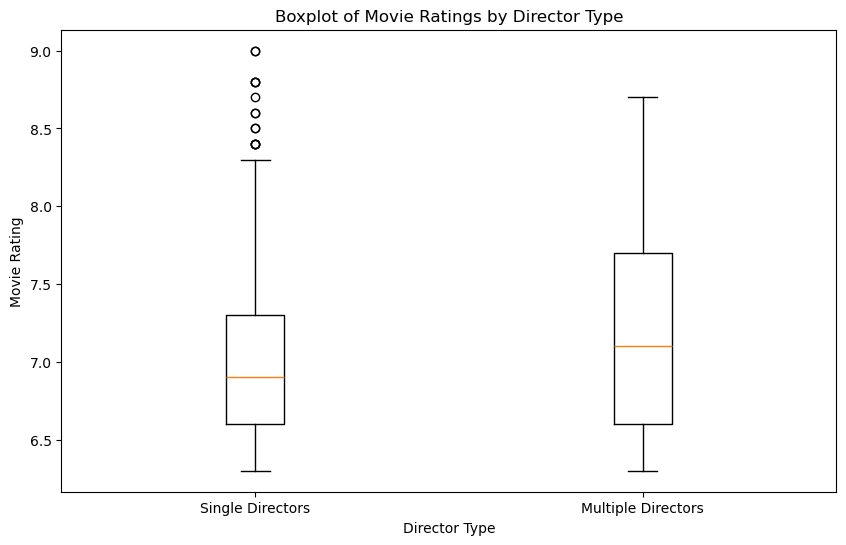

The mean score for movies directed by an individual was 7.02, whereas the mean score for movies directed by multiple directors was 7.18


In [71]:
# Separate the data for Single Directors and Multiple Directors
single_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Single Director']['Rating']
multiple_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Multiple Directors']['Rating']

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([single_directors_ratings, multiple_directors_ratings], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Movie Rating')
plt.title('Boxplot of Movie Ratings by Director Type')
plt.show()
# Not sure if this is something noteable, but I'll save it just in case. Mean rating (red line) for Single Directors is 6.75, 
# while the mean rating for multiple directors is 6.84.
single_mean_score = round(single_directors_ratings.mean(),2)
multiple_mean_score = round(multiple_directors_ratings.mean(),2)
print(f"The mean score for movies directed by an individual was {single_mean_score}, whereas the mean score for movies directed by multiple directors was {multiple_mean_score}")

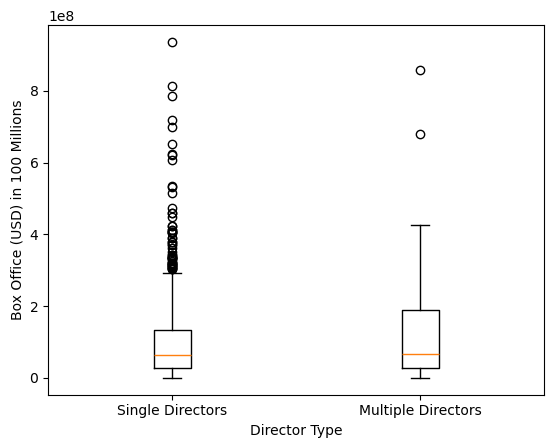

In [72]:
cleaned_boxoffice = clean_movie_df.loc[(clean_movie_df['Box Office'] != "Box Office not found") & (clean_movie_df['Box Office'].notna())]
cleaned_boxoffice['Box Office'] = cleaned_boxoffice['Box Office'].str.replace('[\$,]', '', regex=True).astype(int)

box_and_directortype = cleaned_boxoffice[['Box Office', 'Director_Type']]

single_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Single Director']['Box Office']
multiple_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Multiple Directors']['Box Office']
plt.boxplot([single_directors_box, multiple_directors_box], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Box Office (USD) in 100 Millions')
plt.show();


In [73]:
# Top Directors dataframe
clean_movie_df['Director']

# Split directors in cells containing multiple directors into separate rows
directors_df = clean_movie_df['Director'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Director')

# Count the occurrences of each director
director_counts = directors_df.value_counts()

# Sort the directors based on the number of movies they have made
most_movies_directors = director_counts.head()


# Display the directors who made the most movies
most_movies_directors_df = most_movies_directors.reset_index()
most_movies_directors_df.columns = ['Director', 'Total Movies Directed']
most_movies_directors_df

,Director,Total Movies Directed
0,Steven Spielberg,11
1,Tony Scott,10
2,Michael Bay,8
3,Richard Donner,8
4,Antoine Fuqua,8


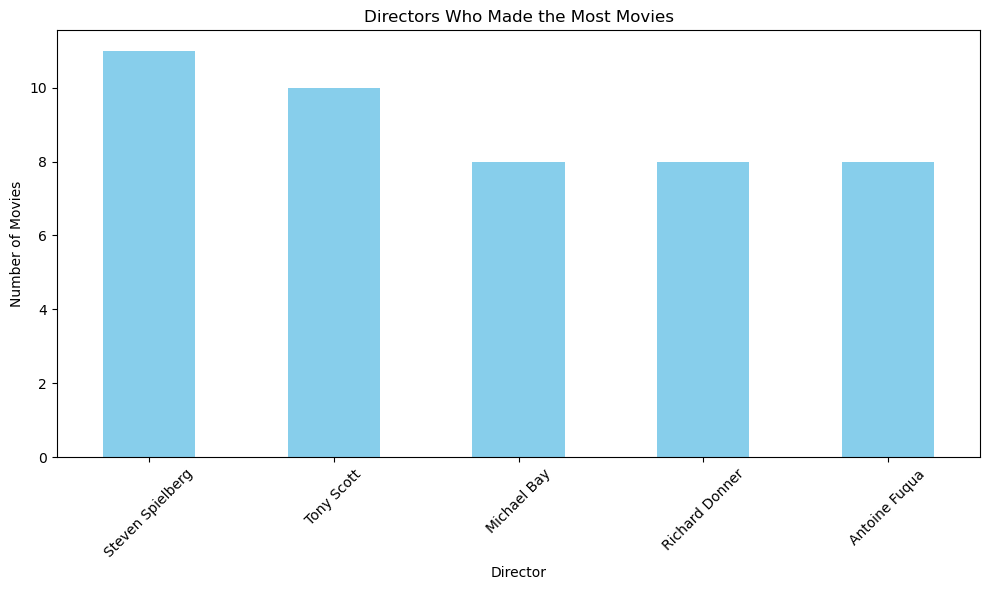

In [74]:

# Plotting the directors who made the most movies as a bar chart
plt.figure(figsize=(10, 6))
most_movies_directors.plot(kind='bar', color='skyblue')
plt.title('Directors Who Made the Most Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show();


C:\Users\jvvil\AppData\Local\Temp\ipykernel_24992\3883171144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_directors_df_clean['Box Office'] = top_directors_df_clean['Box Office'].str.replace('[$,]', '', regex=True).astype(int)


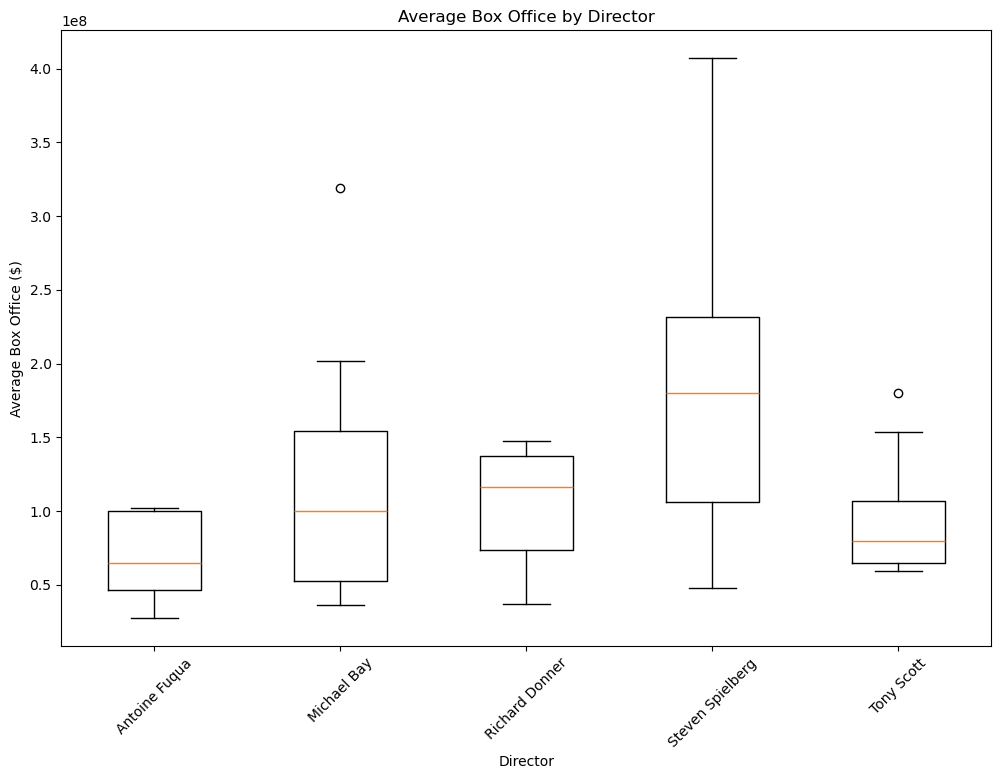

The average box office for director Antoine Fuqua is $68,687,081.38
The average box office for director Michael Bay is $124,732,097.12
The average box office for director Richard Donner is $104,578,117.38
The average box office for director Steven Spielberg is $179,129,347.91
The average box office for director Tony Scott is $94,769,837.40


In [75]:
# List of the top 5 directors
top_directors = ['Steven Spielberg', 'Tony Scott', 'Michael Bay', 'Richard Donner', 'Antoine Fuqua']

# Create a new DataFrame with rows that match the top directors
top_directors_df = clean_movie_df[clean_movie_df['Director'].str.contains('|'.join(top_directors))].sort_values(by='Director')

# Display the new DataFrame
top_directors_df_clean = top_directors_df[['Director', 'Movie_Title', 'Rating', 'main_genre', 'Awards', 'Rotten Tomatoes Rating',
                                           'IMDb Rating', 'Metascore', 'Box Office']]

top_directors_df_clean['Box Office'] = top_directors_df_clean['Box Office'].str.replace('[$,]', '', regex=True).astype(int)
top_directors_df_clean



top_directors_df_clean_split = top_directors_df_clean.assign(Director=top_directors_df_clean['Director'].str.split(', ')).explode('Director')

# I needed to delete one director that got included with Richard Donner
delete = 634
top_directors_df_clean_split = top_directors_df_clean_split.drop(delete)

average_box_office = top_directors_df_clean_split.groupby('Director')['Box Office'].mean().reset_index()
# Create a box plot using matplotlib with average box office values
plt.figure(figsize=(12, 8))
plt.boxplot([top_directors_df_clean_split[top_directors_df_clean_split['Director'] == director]['Box Office'] for director in average_box_office['Director']])
plt.xticks(range(1, len(average_box_office['Director']) + 1), average_box_office['Director'], rotation=45)
plt.title('Average Box Office by Director')
plt.xlabel('Director')
plt.ylabel('Average Box Office ($)')
plt.show()

for index, row in average_box_office.iterrows():
    average_box_office_style = '{:,.2f}'.format(row['Box Office'])
    print(f"The average box office for director {row['Director']} is ${average_box_office_style}")

In [85]:
#Transforming Metascore from Object into Float to get summary stats
clean_movie_df['Metascore'].astype(float).describe()

count    758.000000
mean      60.608179
std       13.480679
min       14.000000
25%       51.000000
50%       60.000000
75%       70.000000
max       98.000000
Name: Metascore, dtype: float64

In [114]:
# Transforming Metascore in the Top 5 Directors into float to get summary stats
top_directors_df_clean_split['Metascore'] = top_directors_df_clean_split['Metascore'].astype(float)
top_director_metascore = top_directors_df_clean_split.groupby('Director')['Metascore'].mean()
top_director_metascore

Director
Antoine Fuqua       52.250000
Michael Bay         47.875000
Richard Donner      58.875000
Steven Spielberg    69.545455
Tony Scott          57.600000
Name: Metascore, dtype: float64

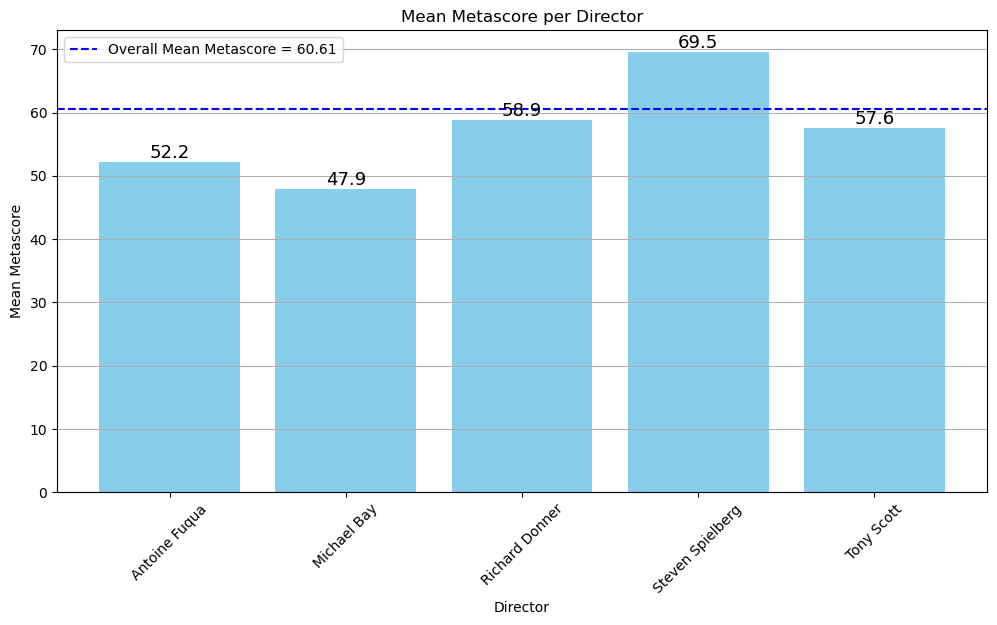

In [125]:
# Data for mean Metascore per director to be used for Bar Graph
director_names = ['Antoine Fuqua', 'Michael Bay', 'Richard Donner', 'Steven Spielberg', 'Tony Scott']
mean_metascores = [52.25, 47.875, 58.875, 69.545455, 57.6]

plt.figure(figsize=(12, 6))
bars = plt.bar(director_names, mean_metascores, color='skyblue')
plt.xlabel('Director')
plt.ylabel('Mean Metascore')
plt.title('Mean Metascore per Director')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Showing a horizontal line of the mean metascore of all movies in the clean_movie_df
plt.axhline(y=60.6, color='b', linestyle='--', label='Overall Mean Metascore = 60.61')
plt.legend()

# Labelling each Bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center', fontsize=13)

plt.show();